In [1]:
%matplotlib inline

import os
import time
import copy
import pandas as pd
import numpy as np

from random import seed
from random import randint
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook as tqdm


input_dir = os.path.join('..','input','imet-2019-fgvc6')
train_dir = os.path.join(input_dir,'train')
test_dir  = os.path.join(input_dir,'test')
labels_csv= os.path.join(input_dir,'labels.csv')
train_csv = os.path.join(input_dir,'train.csv')
resnet_weights_path = os.path.join('..','input','resnet50','resnet50.pth')

In [2]:
def seed_all(seed=27):
    """https://pytorch.org/docs/stable/notes/randomness.html"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_all(27)

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 20
PERCENTILE = 99.7
LEARNING_RATE = 0.0001
DISABLE_TQDM = True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df = pd.read_csv(labels_csv)
attribute_dict = dict(zip(df.attribute_id,df.attribute_name))
del df,labels_csv

In [6]:
tag_count = 0 
culture_count = 0
for idx,data in attribute_dict.items():
    if data.split("::")[0] == 'tag':
        tag_count+=1
    if data.split("::")[0] == 'culture':
        culture_count+=1
print('total_categories: {0}\ntag_categories: {1} \nculture_categories: {2} ' \
      .format(len(attribute_dict),tag_count,culture_count))
#cross check your results
assert tag_count+culture_count == len(attribute_dict)
output_dim = len(attribute_dict) 

total_categories: 1103
tag_categories: 705 
culture_categories: 398 


In [7]:
df = pd.read_csv(train_csv)
labels_dict = dict(zip(df.id,df.attribute_ids))

culture::assyrian
tag::decorative elements


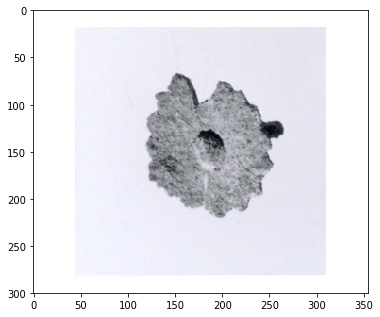

In [8]:
idx = len(os.listdir(train_dir))
number = randint(0,idx)
image_name = os.listdir(train_dir)[number]
def imshow(image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.show()
# Example image
x = Image.open(os.path.join(train_dir,image_name))
for i in labels_dict[os.listdir(train_dir)[number].split('.')[0]].split():
    print(attribute_dict[int(i)])
np.array(x).shape
imshow(x)

In [9]:
# need to add more transforms here
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ])

# Custom Dataset class

In [10]:
from torch.utils import data
class ImageData(data.Dataset):
    def __init__(self,df,dirpath,transform,test = False):
        self.df = df
        self.test = test
        self.dirpath = dirpath
        self.conv_to_tensor = transform
        #image data 
        if not self.test:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0]+'.png')
        else:
            self.image_arr = np.asarray(str(self.dirpath)+'/'+self.df.iloc[:, 0])
        
        #labels data
        if not self.test:
             self.label_df = self.df.iloc[:,1]
        
        # Calculate length of df
        self.data_len = len(self.df.index)

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        image_name = self.image_arr[idx]
        img = Image.open(image_name)
        img_tensor = self.conv_to_tensor(img)
        if not self.test:
            image_labels = self.label_df[idx]
            label_tensor = torch.zeros((1, output_dim))
            for label in image_labels.split():
                label_tensor[0, int(label)] = 1
            image_label = torch.tensor(label_tensor,dtype= torch.float32)
            return (img_tensor,image_label.squeeze())
        return (img_tensor)

In [11]:
df = pd.read_csv(train_csv)
# if you want to run on less data to quickly check
#df = pd.read_csv(train_csv).head(5000)
from sklearn.model_selection import train_test_split
train_df,val_df = train_test_split(df, test_size=0.20)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Validation_Data Length: {len(val_df)}\n Train_Data Length: {len(train_df)}")

Validation_Data Length: 21848
 Train_Data Length: 87389


In [12]:
# Train dataset
train_dataset = ImageData(train_df,train_dir,data_transforms)
train_loader = data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=False)

# validation dataset
val_dataset = ImageData(val_df,train_dir,data_transforms)
val_loader = data.DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle=False)

# test dataset
test_df = pd.DataFrame(os.listdir(test_dir))
test_dataset = ImageData(test_df,test_dir,data_transforms,test = True)
test_loader = data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False)

dataloaders_dict = {'train':train_loader, 'val':val_loader}

In [13]:
features, labels = next(iter(train_loader))
print(f'Train Features: {features.shape}\nTrain Labels: {labels.shape}')
print()
features, labels = next(iter(val_loader))
print(f'Validation Features: {features.shape}\nValidation Labels: {labels.shape}')
print()
features = next(iter(test_loader))
print(f'Test Features: {features.shape}\n')

Train Features: torch.Size([128, 3, 224, 224])
Train Labels: torch.Size([128, 1103])

Validation Features: torch.Size([128, 3, 224, 224])
Validation Labels: torch.Size([128, 1103])

Test Features: torch.Size([128, 3, 224, 224])



# Model Using Resnet50

In [14]:
resnet_cls = models.resnet50()
resnet_cls.load_state_dict(torch.load(resnet_weights_path))

class AvgPool(nn.Module):
    def forward(self, x):
        return F.avg_pool2d(x, x.shape[2:])
    
class ResNet50(nn.Module):
    def __init__(self,num_outputs):
        super(ResNet50,self).__init__()
        self.resnet = resnet_cls
        layer4 = self.resnet.layer4
        self.resnet.layer4 = nn.Sequential(
                                    nn.Dropout(0.5),
                                    layer4
                                    )
        self.resnet.avgpool = AvgPool()
        self.resnet.fc = nn.Linear(2048, num_outputs)
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
            
    def forward(self,x):
        out = self.resnet(x)
        return out
    
NeuralNet = ResNet50(num_outputs = output_dim) 

In [15]:
NeuralNet

ResNet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2

In [16]:
total_params = sum(p.numel() for p in NeuralNet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in NeuralNet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,768,079 total parameters.
17,224,783 training parameters.


In [17]:
print("TRAINING")
print("training examples: ",len(train_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(train_loader))
print()
print("TESTING")
print("validation examples: ",len(val_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(val_loader))
print()
print("VALIDATION")
print("testing examples: ",len(test_dataset))
print("batch size: ",BATCH_SIZE)
print("batches available: ",len(test_loader))

TRAINING
training examples:  87389
batch size:  128
batches available:  683

TESTING
validation examples:  21848
batch size:  128
batches available:  171

VALIDATION
testing examples:  7443
batch size:  128
batches available:  59


# Train the Model

In [18]:
NeuralNet = NeuralNet.to(device)
optimizer = optim.Adam(NeuralNet.parameters(),lr = LEARNING_RATE)
loss_func = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience = 2)
best_loss = np.inf
for epoch in range(NUM_EPOCHS):
    for phase in ['train', 'val']:
        start_time = time.time()
        if phase == 'train':
            NeuralNet.train()
        else:
            NeuralNet.eval()
            
        running_loss = 0.0
        for images_batch, labels_batch in tqdm(dataloaders_dict[phase],disable = DISABLE_TQDM):
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                pred_batch = NeuralNet(images_batch)
                loss = loss_func(pred_batch,labels_batch)
                
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * images_batch.size(0)    
        epoch_loss = running_loss / len(dataloaders_dict[phase].dataset)            

        if phase == 'val' and epoch_loss < best_loss:            
            print("model val_loss Improved from {:.8f} to {:.8f}".format(best_loss,epoch_loss))
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(NeuralNet.state_dict())
        
        if phase == 'val':
            scheduler.step(epoch_loss)
        
        elapsed_time = time.time()-start_time
        print("Phase: {} | Epoch: {}/{} | {}_loss:{:.8f} | Time: {:.4f}s".format(phase,
                                                                              epoch+1,
                                                                              NUM_EPOCHS,
                                                                              phase,
                                                                              epoch_loss,
                                                                              elapsed_time))
NeuralNet.load_state_dict(best_model_wts)

Phase: train | Epoch: 1/20 | train_loss:0.02759083 | Time: 1020.3523s
model val_loss Improved from inf to 0.01205008
Phase: val | Epoch: 1/20 | val_loss:0.01205008 | Time: 242.5033s
Phase: train | Epoch: 2/20 | train_loss:0.01108181 | Time: 1019.1168s
model val_loss Improved from 0.01205008 to 0.01037972
Phase: val | Epoch: 2/20 | val_loss:0.01037972 | Time: 235.0539s
Phase: train | Epoch: 3/20 | train_loss:0.00987623 | Time: 974.0747s
model val_loss Improved from 0.01037972 to 0.00965139
Phase: val | Epoch: 3/20 | val_loss:0.00965139 | Time: 229.2483s
Phase: train | Epoch: 4/20 | train_loss:0.00913306 | Time: 985.1822s
model val_loss Improved from 0.00965139 to 0.00927821
Phase: val | Epoch: 4/20 | val_loss:0.00927821 | Time: 230.8872s
Phase: train | Epoch: 5/20 | train_loss:0.00857142 | Time: 981.3410s
model val_loss Improved from 0.00927821 to 0.00903705
Phase: val | Epoch: 5/20 | val_loss:0.00903705 | Time: 228.4492s
Phase: train | Epoch: 6/20 | train_loss:0.00809647 | Time: 977.30

# Predictions from the model

In [19]:
NeuralNet.eval()
predictions = np.zeros((len(test_dataset), output_dim))
i = 0
for test_batch in tqdm(test_loader,disable = DISABLE_TQDM):
    test_batch = test_batch.to(device)
    batch_prediction = NeuralNet(test_batch).detach().cpu().numpy()
    predictions[i * BATCH_SIZE:(i+1) * BATCH_SIZE, :] = batch_prediction
    i+=1

# Generating submission 

In [20]:
predicted_class_idx = []
for i in range(len(predictions)):         
    idx_list = np.where(predictions[i] > np.percentile(predictions[i],PERCENTILE))    
    predicted_class_idx.append(idx_list[0])

In [21]:
test_df['attribute_ids'] = predicted_class_idx
test_df['attribute_ids'] = test_df['attribute_ids'].apply(lambda x : ' '.join(map(str,list(x))))
test_df = test_df.rename(columns={0: 'id'})
test_df['id'] = test_df['id'].apply(lambda x : x.split('.')[0])
test_df.head()

,id,attribute_ids
0,b7bb1254bf81c71e,79 304 487 1062
1,a6689c35fce7a4ea,13 79 121 1039
2,d0801eed43ebf742,121 161 800 1092
3,8cbcbba676d26bec,554 612 671 780
4,b899b628ae6db634,13 156 813 1092


In [22]:
test_df.to_csv('submission.csv',index = False)